In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import entropy
import numpy as np
import altair as alt 
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'plotly'

In [4]:
# load in data from our 3 California national Parks 
df_redwood = pd.read_excel("redwood.xlsx")
df_joshua = pd.read_excel("joshua.xlsx")
df_sequoia = pd.read_excel("sequoia.xlsx")

# combine them into one dataframe
df_combined = pd.concat([df_redwood, df_joshua, df_sequoia], ignore_index=True)
df_combined.shape

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [5]:
# look at missing values by column
df_combined.isnull().sum()

NameError: name 'df_combined' is not defined

In [95]:
# drop columns with large amount of missing values
df_combined = df_combined.drop(['Region', 'Internal Park Tags', 'ExternalLinks', 'Ozone', 'Park Tags', 'Nativeness Tags'], axis=1)
df_combined.shape

(10661, 27)

In [97]:
df_combined["Occurrence"].value_counts()

Occurrence
Present             4309
Unconfirmed          500
Probably Present     446
Not In Park           91
Name: count, dtype: int64

In [98]:
# drop species not in park or unconfirmed
df_combined = df_combined[~df_combined['Occurrence'].isin(['Not In Park', 'Unconfirmed'])]
df_combined.shape

(10070, 27)

In [116]:
species_distribution_by_park = df_combined.groupby(['Category', 'Park Name'])['Scientific Name'].nunique().reset_index()

# Rename columns for clarity
species_distribution_by_park.columns = ['Category', 'Park Name', 'Species Count']

# Create the grouped bar chart using Altair
species_distribution_chart = alt.Chart(species_distribution_by_park).mark_bar().encode(
    x=alt.X('Category:N', title='Category', axis=alt.Axis(labelAngle=-45), sort=None),  # Categories on the x-axis
    y=alt.Y('Species Count:Q', title='Number of Unique Species'),  # Species count on the y-axis
    color=alt.Color('Park Name:N', title='Park Name'),  # Color by Park Name
    tooltip=['Category', 'Park Name', 'Species Count'],  # Tooltip with additional information
    xOffset='Park Name:N'  # Group the bars by Park Name within each category
).properties(
    width=800,
    height=400,
    title='Species Families by Number of Unique Species Across Parks'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16
)

# Show the chart
species_distribution_chart

alt.Chart(...)

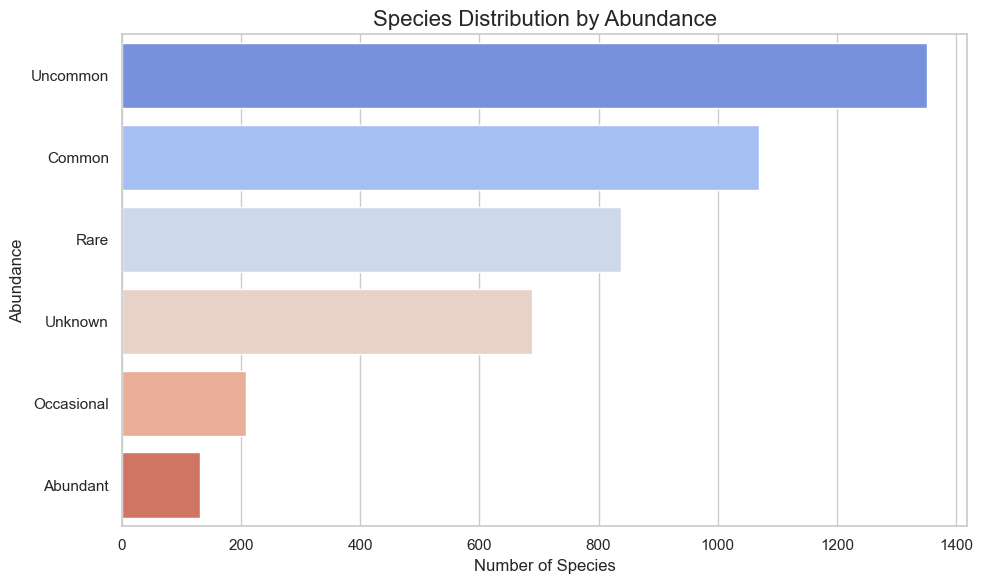

In [118]:
abundance_distribution = df_combined['Abundance'].value_counts().reset_index()

# Rename columns for clarity
abundance_distribution.columns = ['Abundance', 'Species Count']

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Species Count', y='Abundance', data=abundance_distribution, palette='coolwarm')

# Add titles and labels
plt.title('Species Distribution by Abundance', fontsize=16)
plt.xlabel('Number of Species', fontsize=12)
plt.ylabel('Abundance', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

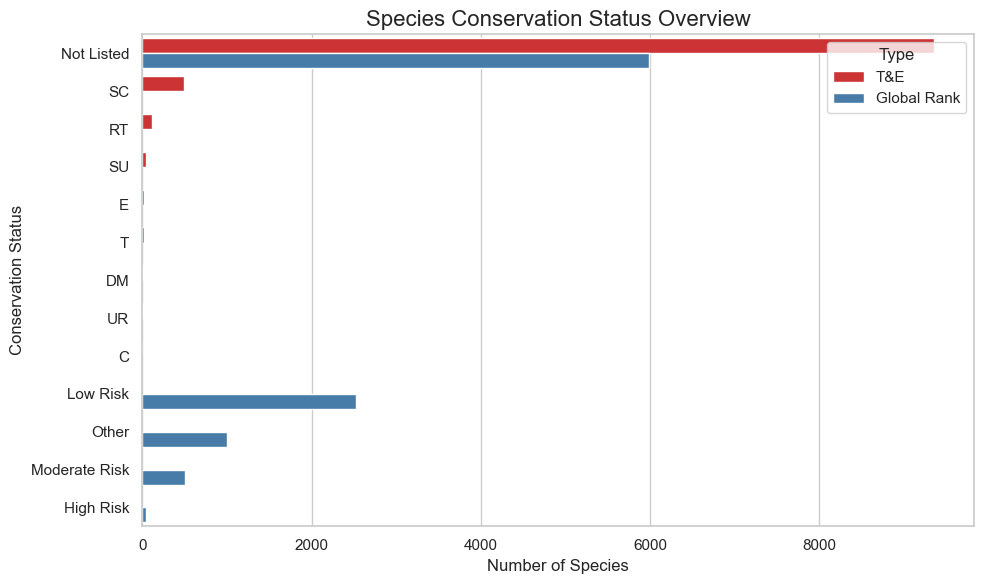

In [123]:
# Simplify T&E column
def simplify_te(te_value):
    if pd.isna(te_value) or te_value not in ['T', 'E', 'SC', 'DM', 'RT', 'SU', 'UR', 'C']:
        return 'Not Listed'
    return te_value

df_combined['T&E Simplified'] = df_combined['T&E'].apply(simplify_te)

# Simplify GRank column into categories
def categorize_grank(grank_value):
    if pd.isna(grank_value) or grank_value in ['GNR', 'GU', 'G5TNR', 'G5?', 'G4?', 'G5T5?', 'G4?', 'GNA']:
        return 'Not Listed'
    elif grank_value in ['G1', 'G2']:
        return 'High Risk'
    elif grank_value in ['G3', 'G4']:
        return 'Moderate Risk'
    elif grank_value == 'G5':
        return 'Low Risk'
    return 'Other'

df_combined['GRank Categorized'] = df_combined['GRank'].apply(categorize_grank)

# Count occurrences for each simplified category
te_counts = df_combined['T&E Simplified'].value_counts().reset_index()
te_counts.columns = ['Conservation Status', 'Count']
te_counts['Type'] = 'T&E'

grank_counts = df_combined['GRank Categorized'].value_counts().reset_index()
grank_counts.columns = ['Conservation Status', 'Count']
grank_counts['Type'] = 'Global Rank'

# Combine counts into a single DataFrame
conservation_counts = pd.concat([te_counts, grank_counts], ignore_index=True)

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=conservation_counts, x='Count', y='Conservation Status', hue='Type', palette='Set1')

# Add titles and labels
plt.title('Species Conservation Status Overview', fontsize=16)
plt.xlabel('Number of Species', fontsize=12)
plt.ylabel('Conservation Status', fontsize=12)

# Show the plot with a legend
plt.legend(title='Type')
plt.tight_layout()
plt.show()

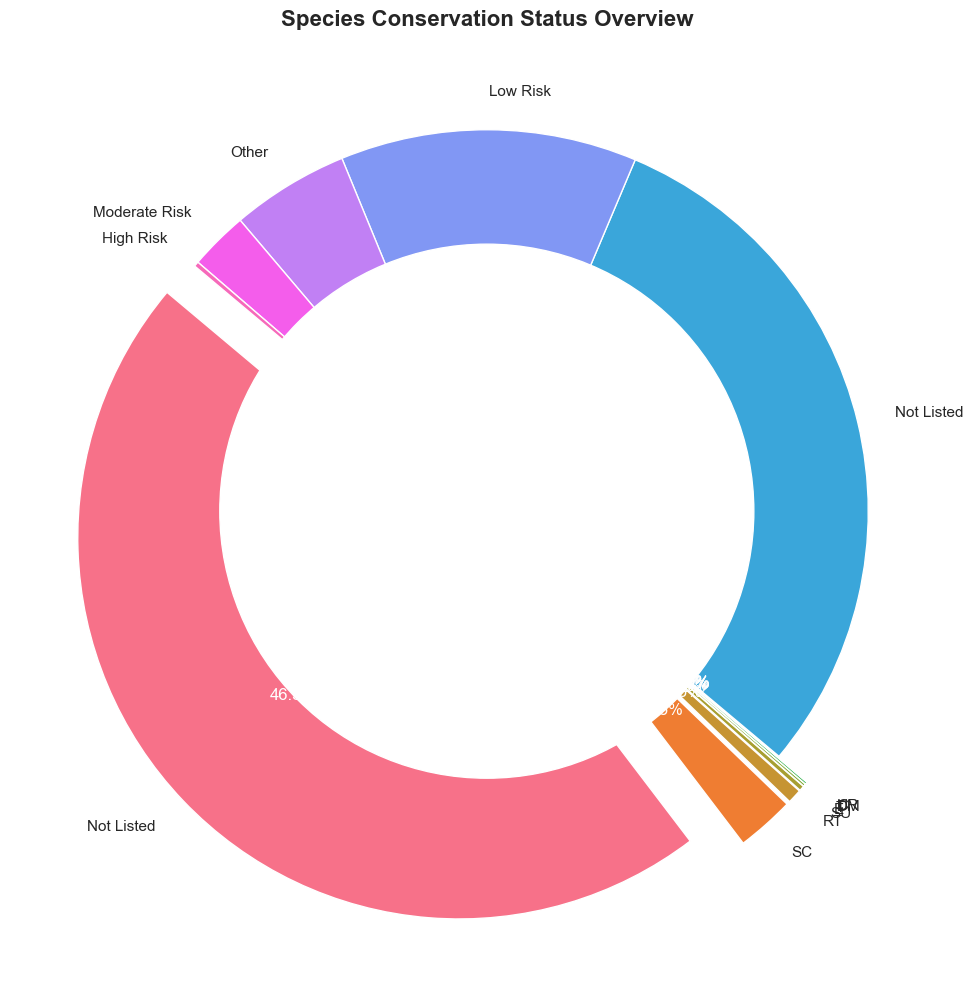

In [124]:
# Set up the plot for a donut chart
plt.figure(figsize=(10, 10))

# Define a color palette with distinct colors for T&E and GRank
colors = sns.color_palette("husl", len(conservation_counts))

# Create the pie chart
wedges, texts, autotexts = plt.pie(
    conservation_counts['Count'],
    labels=conservation_counts['Conservation Status'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=[0.1 if t == 'T&E' else 0 for t in conservation_counts['Type']]  # Slightly explode T&E sections
)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.title('Species Conservation Status Overview', fontsize=16, fontweight='bold')

# Customize text colors
for text in autotexts:
    text.set_color('white')

plt.show()

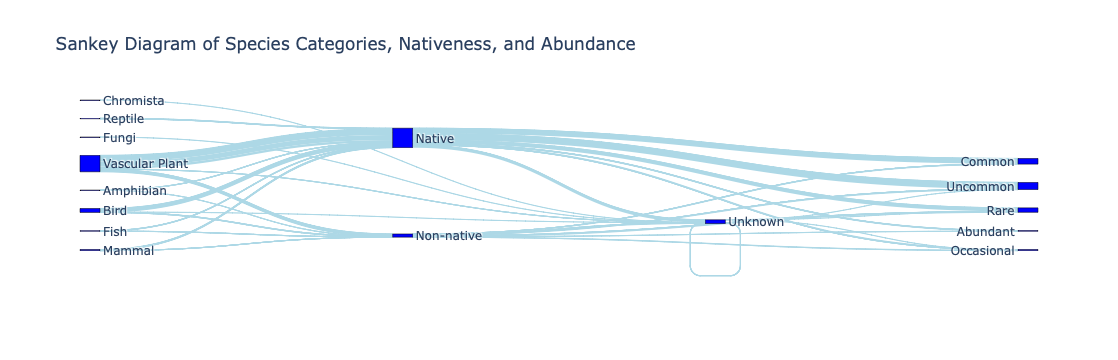

In [133]:
# Prepare the data by grouping by 'Category', 'Abundance', and 'Nativeness', counting occurrences
sankey_data = df_combined.groupby(['Category', 'Abundance', 'Nativeness']).size().reset_index(name='Count')

# Create lists of unique 'Category', 'Abundance', and 'Nativeness' values for Sankey nodes
categories = sankey_data['Category'].unique().tolist()
abundances = sankey_data['Abundance'].unique().tolist()
nativeness = sankey_data['Nativeness'].unique().tolist()

# Combine all nodes into one list of nodes
# Nativeness nodes will be inserted in between categories and abundances
all_nodes = categories + nativeness + abundances

# Create a dictionary for node labels to numeric indices
node_indices = {node: i for i, node in enumerate(all_nodes)}

# Initialize source and target lists
sources = []
targets = []
values = []

# Map the sources and targets for the first link (Category to Nativeness)
for _, row in sankey_data.iterrows():
    category_index = node_indices[row['Category']]
    nativeness_index = node_indices[row['Nativeness']]
    abundance_index = node_indices[row['Abundance']]
    
    # Add the flow from Category to Nativeness
    sources.append(category_index)
    targets.append(nativeness_index)
    values.append(row['Count'])
    
    # Add the flow from Nativeness to Abundance
    sources.append(nativeness_index)
    targets.append(abundance_index)
    values.append(row['Count'])

# Step 2: Create the Sankey Diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,            # Padding between nodes
        thickness=20,      # Thickness of nodes
        line=dict(color="black", width=0.5),
        label=all_nodes,   # The labels for the nodes
        color="blue"       # Color for nodes
    ),
    link=dict(
        source=sources,    # Indices of source nodes
        target=targets,    # Indices of target nodes
        value=values,      # The values (flows) between nodes
        color="lightblue"  # Color for the links
    )
))

# Add a title and show the figure
fig.update_layout(title_text="Sankey Diagram of Species Categories, Nativeness, and Abundance", font_size=12)
fig.show()

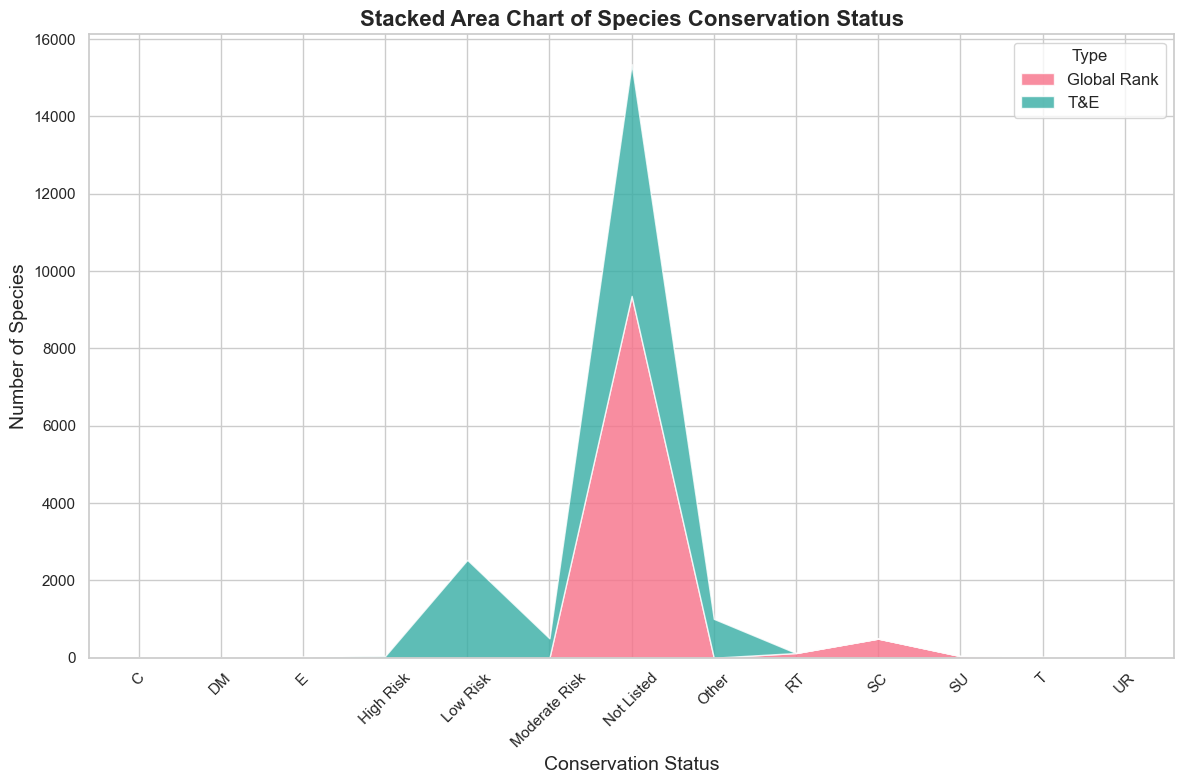

In [125]:
# Pivot the data for area plot
area_data = conservation_counts.pivot(index='Conservation Status', columns='Type', values='Count').fillna(0)

# Set up the plot for a stacked area chart
plt.figure(figsize=(12, 8))
plt.stackplot(area_data.index, area_data['T&E'], area_data['Global Rank'], labels=area_data.columns,
              colors=sns.color_palette("husl", 2), alpha=0.8)

# Customize the chart
plt.title('Stacked Area Chart of Species Conservation Status', fontsize=16, fontweight='bold')
plt.xlabel('Conservation Status', fontsize=14)
plt.ylabel('Number of Species', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Type', fontsize=12)

# Show gridlines
plt.grid(visible=True)

# Show the plot
plt.tight_layout()
plt.show()

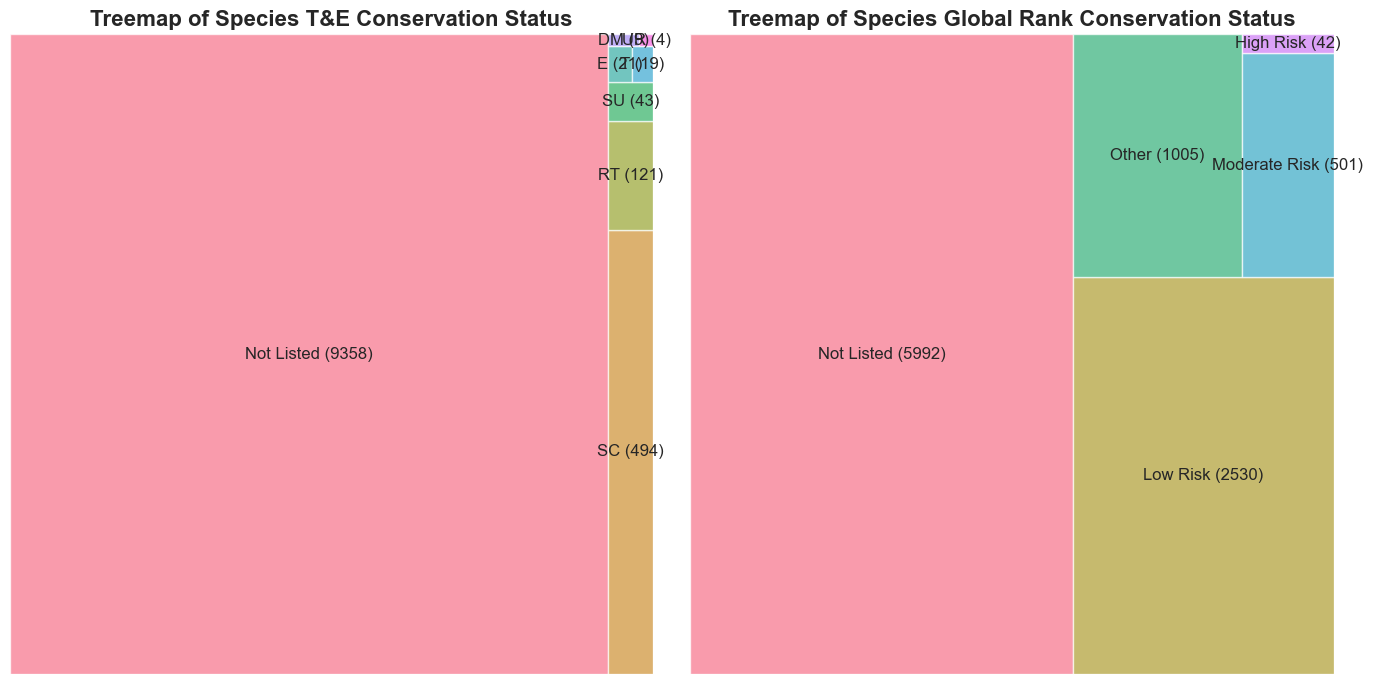

In [127]:
# Filter out categories with 3 or fewer rows
te_counts = te_counts[te_counts['Count'] > 3]
grank_counts = grank_counts[grank_counts['Count'] > 3]

# Plotting separate treemaps for T&E and GRank
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Treemap for T&E
if not te_counts.empty:
    te_counts['Label'] = te_counts['Conservation Status'] + ' (' + te_counts['Count'].astype(str) + ')'
    squarify.plot(sizes=te_counts['Count'], 
                  label=te_counts['Label'], 
                  color=sns.color_palette("husl", len(te_counts)), 
                  alpha=0.7, ax=axes[0])
    axes[0].set_title('Treemap of Species T&E Conservation Status', fontsize=16, fontweight='bold')
    axes[0].axis('off')  # Turn off the axis
else:
    axes[0].text(0.5, 0.5, 'No T&E categories left after filtering.', 
                 fontsize=14, ha='center', va='center')
    axes[0].axis('off')  # Turn off the axis

# Treemap for GRank
if not grank_counts.empty:
    grank_counts['Label'] = grank_counts['Conservation Status'] + ' (' + grank_counts['Count'].astype(str) + ')'
    squarify.plot(sizes=grank_counts['Count'], 
                  label=grank_counts['Label'], 
                  color=sns.color_palette("husl", len(grank_counts)), 
                  alpha=0.7, ax=axes[1])
    axes[1].set_title('Treemap of Species Global Rank Conservation Status', fontsize=16, fontweight='bold')
    axes[1].axis('off')  # Turn off the axis
else:
    axes[1].text(0.5, 0.5, 'No GRank categories left after filtering.', 
                 fontsize=14, ha='center', va='center')
    axes[1].axis('off')  # Turn off the axis

# Show the plot
plt.tight_layout()
plt.show()


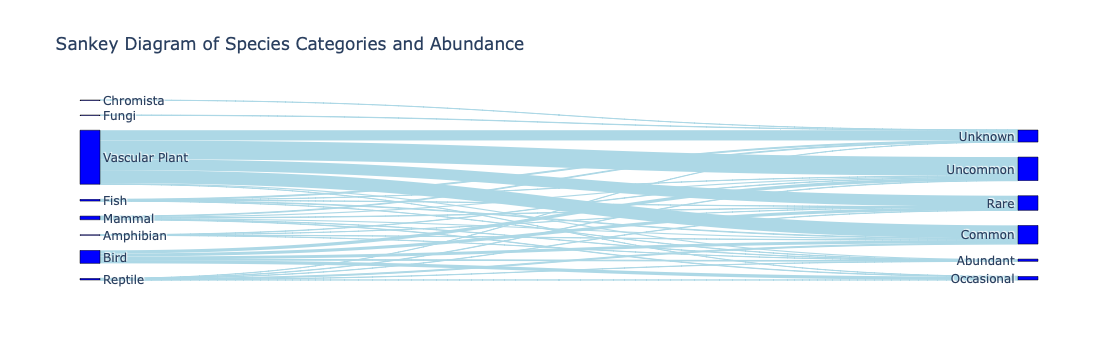

In [128]:
# Prepare the data by grouping by 'Category' and 'Abundance' and counting occurrences
sankey_data = df_combined.groupby(['Category', 'Abundance']).size().reset_index(name='Count')

# Create lists of unique 'Category' and 'Abundance' values for Sankey nodes
categories = sankey_data['Category'].unique().tolist()
abundances = sankey_data['Abundance'].unique().tolist()

# Combine both categories and abundances into one list of nodes
all_nodes = categories + abundances

# Create a dictionary for node labels to numeric indices
node_indices = {node: i for i, node in enumerate(all_nodes)}

# Map source and target nodes to their corresponding indices
sankey_data['source'] = sankey_data['Category'].map(node_indices)
sankey_data['target'] = sankey_data['Abundance'].map(node_indices)

# Extract the source, target, and value (flow) data for the Sankey diagram
sources = sankey_data['source'].tolist()
targets = sankey_data['target'].tolist()
values = sankey_data['Count'].tolist()

# Step 2: Create the Sankey Diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,            # Padding between nodes
        thickness=20,      # Thickness of nodes
        line=dict(color="black", width=0.5),
        label=all_nodes,   # The labels for the nodes
        color="blue"       # Color for nodes
    ),
    link=dict(
        source=sources,    # Indices of source nodes
        target=targets,    # Indices of target nodes
        value=values,      # The values (flows) between nodes
        color="lightblue"  # Color for the links
    )
))

# Add a title and show the figure
fig.update_layout(title_text="Sankey Diagram of Species Categories and Abundance", font_size=12)
fig.show()